In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load csv
df = pd.read_csv("modeling_test_data.csv")
df.head()

,date,sales,m_tv,m_rd,m_online,price,promo,holidays
0,3/26/2017,5.206100,0.596845,0.471012,0.227368,-0.128877,9,NaN
1,4/2/2017,5.385093,0.618830,0.482700,0.226155,-0.078913,15,NaN
2,4/9/2017,5.230386,0.606462,0.468500,0.210219,-0.016652,9,NaN
3,4/16/2017,5.078445,0.547290,0.452152,0.197514,0.054442,14,1.0
4,4/23/2017,5.216146,0.469708,0.434500,0.200274,0.121796,8,NaN


## Exploratory Data Analysis (EDA)

In [3]:
# summary statistics
df.describe()

,sales,m_tv,m_rd,m_online,price,promo,holidays
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,30.0
mean,5.184400,0.560531,0.418528,0.209329,-0.001423,10.532609,1.0
std,0.108638,0.064835,0.038475,0.019127,0.060020,4.031336,0.0
min,4.857496,0.366586,0.294887,0.142494,-0.140803,2.000000,1.0
25%,5.116671,0.514974,0.396311,0.198650,-0.040600,8.000000,1.0
50%,5.201595,0.578128,0.426288,0.212973,0.001642,10.000000,1.0
75%,5.265476,0.611251,0.442458,0.224060,0.035743,13.000000,1.0
max,5.385093,0.656982,0.484950,0.236512,0.151495,22.000000,1.0


In [4]:
# null values
null_counts = df.isnull().sum()
non_null_counts = df.count()
null_percentages = round(df.isnull().mean() * 100, 2)

# null table
df_null = pd.DataFrame({'Null Count': null_counts, 'Non-Null Count': non_null_counts, 'Null Percentage': null_percentages})
df_null = df_null.reset_index()
df_null

,index,Null Count,Non-Null Count,Null Percentage
0,date,0,92,0.00
1,sales,0,92,0.00
2,m_tv,0,92,0.00
3,m_rd,0,92,0.00
4,m_online,0,92,0.00
5,price,0,92,0.00
6,promo,0,92,0.00
7,holidays,62,30,67.39


In [5]:
# data imputation

## drop date column since it does not impact sales
df = df.drop('date', axis=1)

## fill missing holiday values with 0 (non-holiday weeks)
df['holidays'] = df['holidays'].fillna(0)

In [6]:
import plotly.express as px
import pandas as pd

# numeric columns for analysis
df_num = df[['sales','m_tv','m_rd','m_online','price','holidays']]

# correlation matrix
corr_matrix = df_num.corr().round(2)

corr_long = corr_matrix.reset_index().melt(id_vars='index')
corr_long.columns = ['Variable 1', 'Variable 2', 'Correlation']

# plotly heatmap
fig = px.imshow(
    corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    color_continuous_scale='RdBu_r',
    zmin=-1,
    zmax=1,
    text_auto=True,
    labels=dict(color='Correlation'),
    title="Correlation Matrix"
)

fig.update_layout(width=600, height=600)
fig.show()


In [7]:
# correlation matrix (with sales as baseline)
df_num.corr()['sales'].sort_values(ascending = False)

sales       1.000000
m_tv        0.713694
m_rd        0.489516
m_online    0.402167
price       0.175108
holidays   -0.223123
Name: sales, dtype: float64

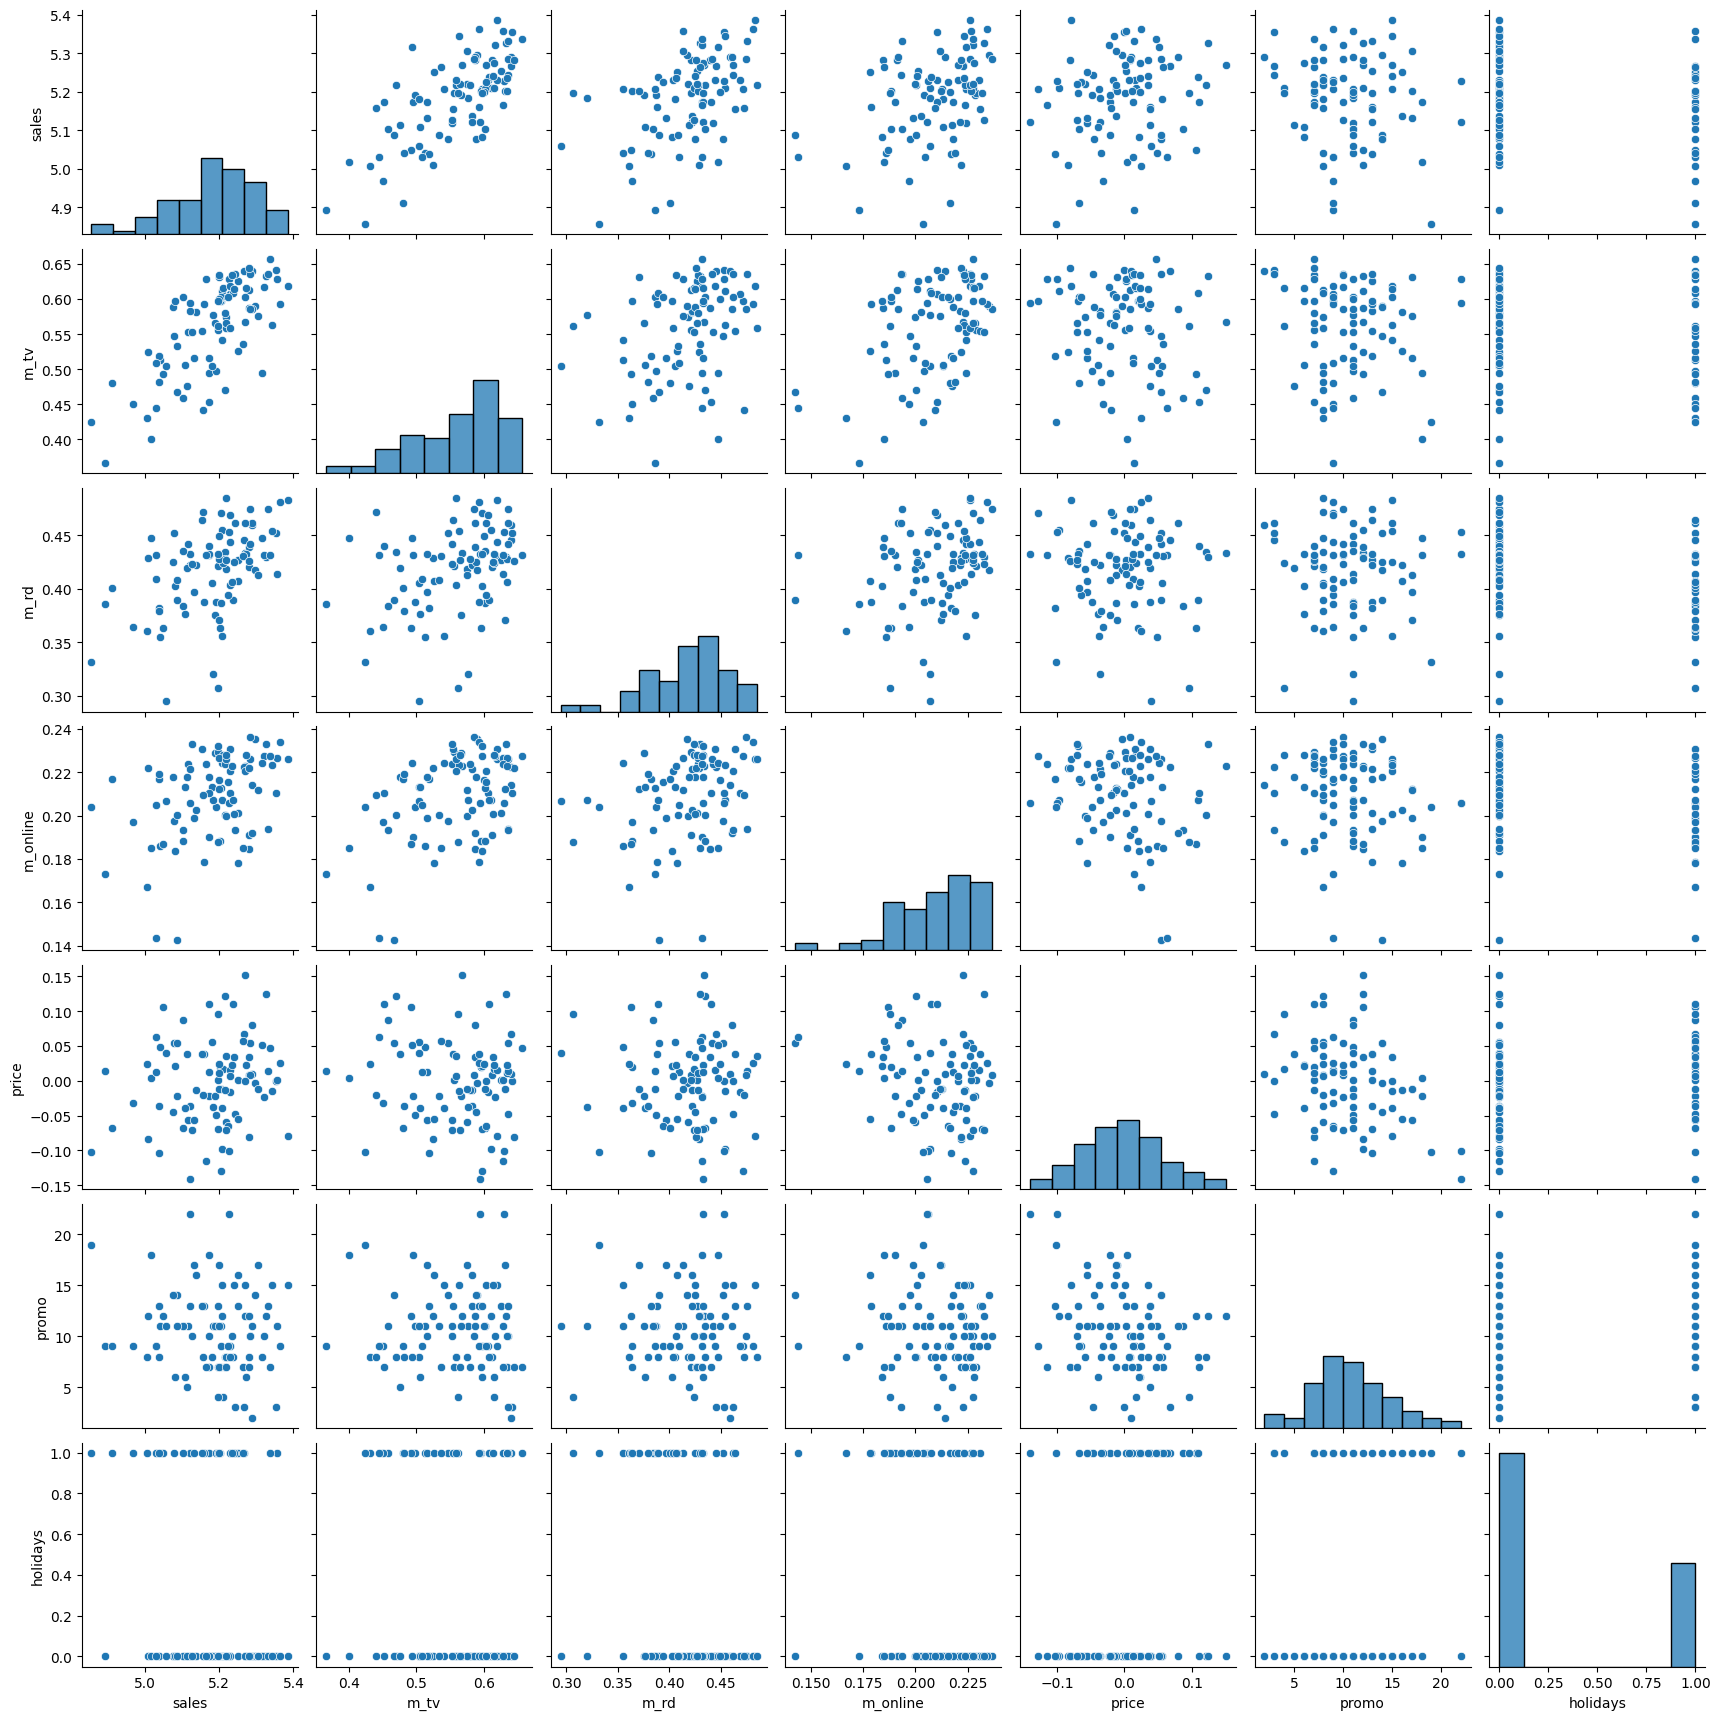

In [8]:
import seaborn as sns

# pair plot
sns.pairplot(df)

In [9]:
import plotly.express as px

num_cols = ['sales','m_tv','m_rd','m_online','price','promo']

for col in num_cols:
    fig = px.histogram(df, x=col, nbins=20, title=f'Distribution of {col}')
    fig.show()

In [10]:
# multicollinearity analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_variables = df[['m_tv','m_rd','m_online','price','promo','holidays']]

# calculate the VIF for X variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,m_tv,100.893943
1,m_rd,111.872070
2,m_online,122.088801
3,price,1.139564
4,promo,8.271845
5,holidays,1.546823


### Feature Engineering

In [11]:
# pairwise ad channel interactions
df['m_tv_rd'] = df['m_tv'] * df['m_rd']
df['m_tv_online'] = df['m_tv'] * df['m_online']
df['m_rd_online'] = df['m_rd'] * df['m_online']

# ad channel and price interactions
df['m_tv_price'] = df['m_tv'] * df['price']
df['m_rd_price'] = df['m_rd'] * df['price']
df['m_online_price'] = df['m_online'] * df['price']

# drop non influential features
df = df.drop(['holidays'], axis=1)

## Data Modeling

In [12]:
from sklearn.model_selection import train_test_split

# defining features and target
X = df.drop('sales', axis=1)
y = df['sales']

# splitting the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)

# scores
r_squared = r2_score(y_test, lin_pred)
rmse = np.sqrt(mean_squared_error(y_test, lin_pred))

print("R²:", r_squared)
print("RMSE:", rmse)

R²: 0.7011735227422773
RMSE: 0.05454666438028962


In [14]:
import pandas as pd
import numpy as np
import plotly.subplots as sp
import plotly.graph_objects as go

predictor_cols = ['m_tv', 'm_rd', 'm_online', 'price', 'promo']
response_col = 'sales'

# Create a 2-row x 3-column subplot grid
fig = sp.make_subplots(rows=2, cols=3, subplot_titles=predictor_cols, vertical_spacing=0.15, horizontal_spacing=0.1)

for i, col in enumerate(predictor_cols):

    row_idx = 1 if i < 3 else 2
    col_idx = i + 1 if i < 3 else i - 2  # For second row: positions 1 and 2
    
    x = df[col]
    y = df[response_col]
    
    # Fit a linear regression (sales ~ predictor)
    slope, intercept = np.polyfit(x, y, 1)
    predicted = slope * x + intercept
    residuals = y - predicted

    trace = go.Scatter(x=x, y=residuals, mode='markers', marker=dict(size=4))
    fig.add_trace(trace, row=row_idx, col=col_idx)
    
    fig.update_xaxes(title_text=col, row=row_idx, col=col_idx)
    fig.update_yaxes(title_text='Residuals', row=row_idx, col=col_idx)

fig.update_layout(
    showlegend=False,
    height=800,
    width=1500,
    title_text="Residual Plots: Sales vs Predictors"
)

fig.show()

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# scores
r_squared = r2_score(y_test, rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print("R²:", r_squared)
print("RMSE:", rmse)

R²: 0.5074956474848886
RMSE: 0.07002670581306172


### XGBoost Regressor

In [16]:
import xgboost as xgb

xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# scores
r_squared = r2_score(y_test, xgb_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("R²:", r_squared)
print("RMSE:", rmse)

R²: 0.5496964511182922
RMSE: 0.06695936789092287


## Data Processing

Ridge and Lasso need scaling to ensure that all features contribute fairly to the penalty term

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Ridge Regression

In [18]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)

# scores
r_squared = r2_score(y_test, ridge_pred)
rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

print("R²:", r_squared)
print("RMSE:", rmse)

R²: 0.6614780145706091
RMSE: 0.05805666705302196


### Lasso Regression

In [19]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)

# scores
r_squared = r2_score(y_test, lasso_pred)
rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

print("R²:", r_squared)
print("RMSE:", rmse)

R²: -0.018384264752596913
RMSE: 0.1006965289495837


## Results

In [20]:
# regression models only
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Linear Coefficient': lin_reg.coef_,
})

print(coeff_df)

           Feature  Linear Coefficient
0             m_tv            2.290330
1             m_rd            0.049158
2         m_online           -3.191293
3            price            0.351588
4            promo            0.000438
5          m_tv_rd           -2.683596
6      m_tv_online           -0.583212
7      m_rd_online            9.932893
8       m_tv_price           -1.869354
9       m_rd_price            0.179457
10  m_online_price            4.992496


In [21]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_test, y=lin_pred,
                         mode='markers',
                         name='Linear Regression',
                         marker=dict(size=8, opacity=0.7)))

fig.add_trace(go.Scatter(x=y_test, y=ridge_pred,
                         mode='markers',
                         name='Ridge Regression',
                         marker=dict(size=8, opacity=0.7)))

fig.add_trace(go.Scatter(x=y_test, y=xgb_pred,
                         mode='markers',
                         name='XGBoost Regression',
                         marker=dict(size=8, opacity=0.7)))

fig.add_trace(go.Scatter(x=[y.min(), y.max()], y=[y.min(), y.max()],
                         mode='lines',
                         name='Identity Line',
                         line=dict(dash='dash', color='black')))

fig.update_layout(title='Actual vs. Predicted Sales',
                  xaxis_title='Actual Sales',
                  yaxis_title='Predicted Sales',
                  legend=dict(x=0.01, y=0.99),
                  width=800,
                  height=600)

fig.show()